In [1]:
import matplotlib
%matplotlib inline

In [2]:
import sys

sys.path.append("../image")
import krige

sys.path.append("../radar")
import pyart_utils as pu


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
import pandas as pd

In [4]:
light_levels = df = pd.read_csv("../image/kriged/2017-09-28_filtd.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])


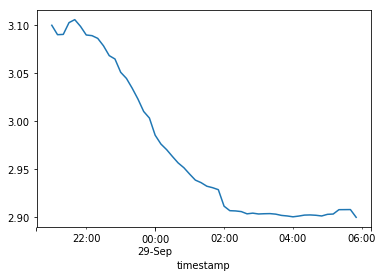

In [5]:
light_levels.groupby("timestamp").z.mean().plot()

In [7]:
def process_radar_csv(fname):
    csv_df = pd.read_csv(fname)
    del csv_df["Unnamed: 0"]
    start = fname.index('KOKX')
    csv_df['Date_Time'] = pd.to_datetime(fname[start+4:start+19],format='%Y%m%d_%H%M%S')
    return csv_df

In [8]:
import glob
fnames = glob.glob("../radar/data/2017-09/28/*.filtered.csv")\
       + glob.glob("../radar/data/2017-09/29/*.filtered.csv")
radar_levels = pd.concat((process_radar_csv(fname)\
                          for fname in fnames))

t_filt = (radar_levels.Date_Time >= "2017-09-28 21:00") & (radar_levels.Date_Time <= "2017-09-29 06:00")
radar_levels = radar_levels[t_filt]

In [9]:
radar_levels = radar_levels.groupby(["lon", "lat"])\
                           .apply(lambda x: x.set_index("Date_Time").dbzh.resample('10T').mean())\
                           .unstack().unstack().reset_index() # black magic

In [10]:
radar_levels = radar_levels.dropna(subset=[0])


In [11]:
import numpy as np
print(radar_levels.Date_Time.nunique())
np.sort(radar_levels.Date_Time.unique())

53


array(['2017-09-28T21:00:00.000000000', '2017-09-28T21:10:00.000000000',
       '2017-09-28T21:20:00.000000000', '2017-09-28T21:30:00.000000000',
       '2017-09-28T21:40:00.000000000', '2017-09-28T21:50:00.000000000',
       '2017-09-28T22:00:00.000000000', '2017-09-28T22:10:00.000000000',
       '2017-09-28T22:20:00.000000000', '2017-09-28T22:30:00.000000000',
       '2017-09-28T22:40:00.000000000', '2017-09-28T22:50:00.000000000',
       '2017-09-28T23:00:00.000000000', '2017-09-28T23:10:00.000000000',
       '2017-09-28T23:30:00.000000000', '2017-09-28T23:40:00.000000000',
       '2017-09-28T23:50:00.000000000', '2017-09-29T00:00:00.000000000',
       '2017-09-29T00:10:00.000000000', '2017-09-29T00:20:00.000000000',
       '2017-09-29T00:30:00.000000000', '2017-09-29T00:40:00.000000000',
       '2017-09-29T00:50:00.000000000', '2017-09-29T01:00:00.000000000',
       '2017-09-29T01:10:00.000000000', '2017-09-29T01:20:00.000000000',
       '2017-09-29T01:30:00.000000000', '2017-09-29

In [15]:
radar_levels.shape, light_levels.shape

((220374, 4), (122094, 8))

In [18]:
mgd = light_levels.merge(radar_levels, 
                    left_on=["timestamp", "x", "y"],
                    right_on=["Date_Time", "lon", "lat"])
mgd.shape

(113367, 12)

In [19]:
mgd['dbzh'] = mgd[0]

In [20]:
np.corrcoef(mgd['dbzh'], mgd["z"])[0,1]

-0.11169061249098906

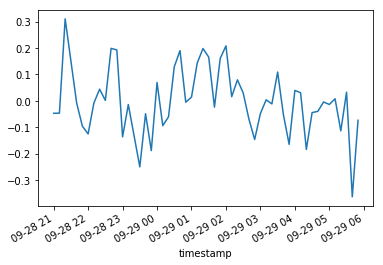

In [21]:
mgd.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot()

In [20]:
mgd.head()

,Unnamed: 0,Unnamed: 0.1,x,y,z,timestamp,geometry,index_right,Date_Time,lat,lon,0,Date_Time_Join,dbzh
0,223,223,-74.014080,40.700173,4.373816,2017-09-27 21:00:00,POINT (-74.0140797410063 40.70017257514655),0,2017-09-27 21:00:00,40.700173,-74.014080,0.0,2017-09-27 21:00:00,0.0
1,224,224,-74.012869,40.700185,4.355886,2017-09-27 21:00:00,POINT (-74.01286857022636 40.7001846163299),0,2017-09-27 21:00:00,40.700185,-74.012869,0.0,2017-09-27 21:00:00,0.0
2,225,225,-74.011657,40.700197,4.239311,2017-09-27 21:00:00,POINT (-74.0116573990083 40.7001966448284),0,2017-09-27 21:00:00,40.700197,-74.011657,0.0,2017-09-27 21:00:00,0.0
3,276,276,-74.015307,40.701078,4.542968,2017-09-27 21:00:00,POINT (-74.0153067937795 40.70107825563972),0,2017-09-27 21:00:00,40.701078,-74.015307,0.0,2017-09-27 21:00:00,0.0
4,277,277,-74.014096,40.701090,4.386978,2017-09-27 21:00:00,POINT (-74.0140956067373 40.70109030974864),0,2017-09-27 21:00:00,40.701090,-74.014096,0.0,2017-09-27 21:00:00,0.0


### Now, filter only over manhattan

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline 
fig, ax = plt.subplots(1, 1, figsize=(6, 11))

krige.in_frame.plot(ax=ax, color='red', alpha=.6)
filt = (krige.out_reset.geometry.centroid.x > -74.03) & (krige.out_reset.geometry.centroid.y > 40.7)
krige.out_reset[filt].plot(ax=ax, color='red', alpha=.6)

ch = gpd.GeoSeries(pd.concat([krige.in_frame.geometry, krige.out_reset[filt].geometry])).unary_union.convex_hull
gpd.GeoSeries([ch]).plot(ax=ax, color='blue', alpha=.4)


In [ ]:
ch_df = gpd.GeoDataFrame({"geometry": gpd.GeoSeries([ch])})

In [ ]:
import shapely.geometry
mgd["geometry"] = mgd[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
mgd = gpd.GeoDataFrame(mgd)
joined = gpd.sjoin(mgd, ch_df)
fig, ax = plt.subplots(1, 1, figsize=(6, 11))
joined.plot(ax=ax)

In [22]:
def fancy_plot(df):
    fig = plt.figure(figsize=(10,7),facecolor='w')
    ax = fig.add_subplot(111)
    lns1 = ax.plot(df['timestamp'].unique(),df.groupby('timestamp').z.mean(), '-o', label = 'Brightness',alpha=0.3)
    ax2 = ax.twinx()
    lns3 = ax2.plot(df['timestamp'].unique(),df.groupby('timestamp').dbzh.mean(), '-r.', label = 'DBZ',alpha=0.3)


    lns = lns1+lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)


    fig.autofmt_xdate()
    #ax.grid()
    ax.set_title('Brightness and DBZ, 10-01',fontsize=18)
    #ax.set_xlim('22017-09-30 19:00:33', '2017-10-01 07:51:52')
    #ax.set_xlim('2017-04-13 21:00:00', '2017-04-29 05:00:00')


    #ax.set_xlim('2017-04-14 21:00:00', '2017-04-15 05:00:00')
    #ax.set_xlim('2017-04-18 21:00:00', '2017-04-19 05:00:00')
    #ax.set_xlim('2017-04-23 21:00:00', '2017-04-24 05:00:00')
    #ax.set_xlim('2017-04-24 21:00:00', '2017-04-25 05:00:00')
    #ax.set_xlim('2017-04-27 21:00:00', '2017-04-28 05:00:00')

    #ax.set_ylim(0, 0.08)

    ax.set_xlabel("Time",fontsize=14)
    ax.set_ylabel("Brightness (log cd)",fontsize=14)
    ax2.set_ylabel("Reflectivity (dBZ)",fontsize=14)

    plt.show()

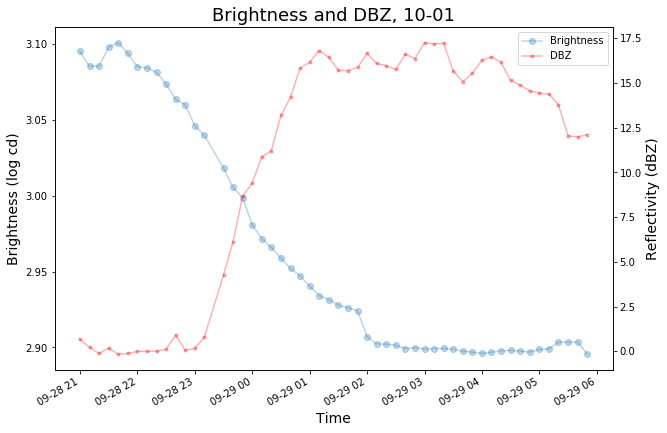

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
fancy_plot(mgd)

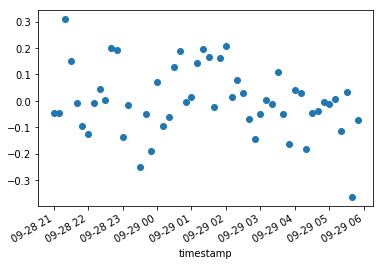

In [24]:
mgd.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot(style='o')

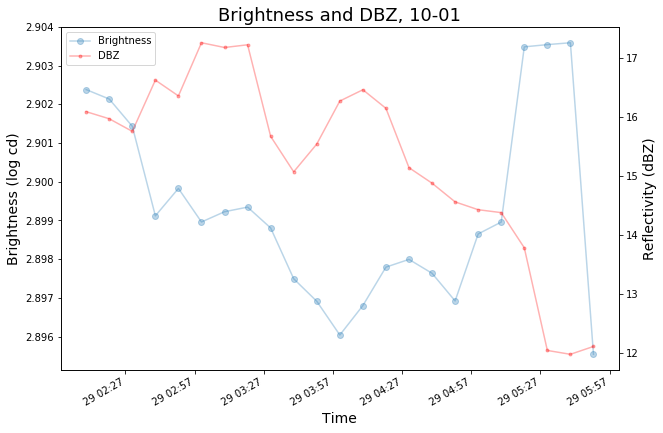

-0.030494016856746475

In [29]:
after_begins = (mgd['timestamp'] > '2017-09-29 02:00:00')
fancy_plot(mgd[after_begins])
np.corrcoef(mgd[after_begins]["dbzh"], mgd[after_begins]["z"])[0,1]

In [26]:
ma = mgd[after_begins].groupby("timestamp")[["dbzh", "z"]].mean()
from sklearn.preprocessing import StandardScaler
dbz = StandardScaler().fit_transform(ma["dbzh"].values.reshape(-1, 1))
bgd = StandardScaler().fit_transform(ma["z"].values.reshape(-1, 1))
np.corrcoef(bgd[:, 0], dbz[:, 0])[1, 0]

-0.9609183099755458